# Mol2Vec Experiments
***

In [1]:
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, mol_to_svg, IdentifierTable, plot_2D_vectors

from gensim.models import Word2Vec

model = Word2Vec.load('db/model_300dim.pkl')

In [2]:
suppl = Chem.SDMolSupplier('db/chembl_01.sdf')

Now, let's create a function that converts the suppl into a list of molecules (Mol type).

In [3]:
def suppl_to_lst(suppl, sample_size):
    # declare a list to store the mols
    ms = []
    # sample size: can be changed accordingly to the size of database
    for i in range(sample_size):
        ms.append(suppl[i])
    
    return ms

Create different sample sizes from suppl

In [4]:
small_moldb100 = suppl_to_lst(suppl, 100)
small_moldb200 = suppl_to_lst(suppl, 200)
small_moldb500 = suppl_to_lst(suppl, 500)
small_moldb1000 = suppl_to_lst(suppl, 1000)
small_moldb2000 = suppl_to_lst(suppl, 2000)
small_moldb5000 = suppl_to_lst(suppl, 5000)

### Clean the database

In [5]:
def clean_db(db, radius):
    not_in_model = []
    none_type = []
    
    # check for nonetype
    for i in range(len(db)):
        mol = db[i]
        # check for nonetype
        if type(mol) == type(None):
            none_type.append(mol)
        
    cleaned1 = list(set(db)-set(none_type))
    
    for i in range(len(cleaned1)):
        mol = cleaned1[i]
        # check if sentence in model or not
        sentences = mol2alt_sentence(mol, radius)
        for s in sentences:
            if s not in model:
                not_in_model.append(mol)
    
    cleaned = list(set(cleaned1)-set(not_in_model))
    return cleaned

Clean the databases, with radius = 1

In [6]:
radius = 1
c_small_moldb100 = clean_db(small_moldb100, radius)
c_small_moldb200 = clean_db(small_moldb200, radius)
c_small_moldb500 = clean_db(small_moldb500, radius)
c_small_moldb1000 = clean_db(small_moldb1000, radius)
c_small_moldb2000 = clean_db(small_moldb2000, radius)
c_small_moldb5000 = clean_db(small_moldb5000, radius)

/home/sabrinaho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


***

In [7]:
from IPython.display import SVG
from rdkit.Chem import rdDepictor as rdd
from rdkit.Chem.Draw import rdMolDraw2D as draw2d

def draw2D(x):
    m = x
    molSize = (450, 150)
    mc = Chem.Mol(m.ToBinary())
    if not mc.GetNumConformers():
        rdd.Compute2DCoords(mc)
    drawer = draw2d.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:','')))

In [8]:
from rdkit import DataStructs
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol

After getting a list of molecules, let's create a function to find the Tanimoto similarity:

In [9]:
def tanimoto_similarity(ms, idx):
    # convert Mol to datastructure type using a list comprehension
    fps = [FingerprintMol(i) for i in ms]

    # set a query molecule: can be changed 
    query = fps[idx]
    # declare new list for similarities
    sim = []
    # loop through to find Tanimoto similarity
    for i in range(len(fps)):
        # tuple: (idx, similarity)
        sim.append((i, DataStructs.FingerprintSimilarity(query, fps[i])))

    # sort sim using the similarities
    sim.sort(key=lambda x:x[1], reverse=True)

    return sim

Before getting into embedding molecules into vectors, I'm going to breifly introduce Word2Vec, which Mol2Vec is based on and is what I will be using.

## What is [Word2Vec](https://en.wikipedia.org/wiki/Word2vec)?
Word2Vec is a two-layer neural networks that input a word corpus and output a vector space. Although Word2Vec is not a deep neural network, it converts words into numerical format that deep nets can understand.


## [Mol2vec](https://github.com/samoturk/mol2vec)
The concept of Mol2Vec is based from Word2Vec, instead of words, it's molecules. 

Now, let's load a molecule database from [chEMBL](ftp://ftp.ebi.ac.uk/pub/databases/chembl/ChEMBLdb/) (same as the one mentioned above)
#### Load molecule database
- len(suppl) = 440055

In [10]:
suppl = Chem.SDMolSupplier('db/chembl_01.sdf')

Now, let's load the first mol in suppl and display it:

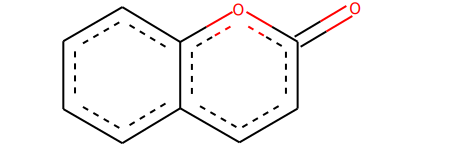

In [11]:
m = suppl[0]
draw2D(m)

### Morgan Fingerprints

In [12]:
from rdkit.Chem import AllChem

##### 1. <rdkit.DataStructs.cDataStructs.UIntSparseIntVect at 0x7fdfcac2f080>

In [13]:
mfp = AllChem.GetMorganFingerprint(m, radius=1)
mfp

By using the function <font color='red'>GetNonzeroElements()</font>, we will get a list of Morgan Fingerprints, as shown below

In [14]:
list(mfp.GetNonzeroElements().keys())

[10565946,
 98513984,
 368713488,
 864942730,
 951226070,
 2360741695,
 2759434019,
 3189457552,
 3217380708,
 3218693969,
 4197146180]

After getting a good understanding of what Mol2Vec is and how Morgan Fingerprints work, let's start by importing some modules:

#### Load trained model
Model training are done using ref: [Mol2Vec](https://github.com/samoturk/mol2vec)
- Model training is replying on Word2Vec implementation of [gensim](https://radimrehurek.com/gensim/models/word2vec.html)

In [15]:
from gensim.models import Word2Vec

model = Word2Vec.load('db/model_300dim.pkl')

### start matching

In [mol2vec/features.py](https://github.com/samoturk/mol2vec/blob/master/mol2vec/features.py) there are two different functions that calculate Morgan Fingerprints: <font color='red'>mol2sentence()</font> and <font color='red'>mol2alt_sentence()</font>
They are the same, except 
- <font color='red'>mol2alt_sentence()</font> only returns the alternating sentences, which is the list of sentences for all radii combined. 

Whereas, 
- <font color='red'>mol2sentence()</font> returns an additional list of sentences for each radius.

In this project, we are using <font color='red'>mol2alt_sentence()</font> since the alternating sentence is the list we need.

<font color='red'>mol2alt_sentence()</font>: a function that 
- parameters 
    - a **mol**
    - a **radius**
- calculates ECFP (**Morgan Fingerprints**)
- returns identifiers of substructions as sentences (strings)

In [16]:
# ms is a molecule list
sentence = mol2alt_sentence(ms[0], 1)

NameError: name 'ms' is not defined

### vectorlizing a molecule
1. declare a variable called **vecNode**: sum of the vectors of all substructures
2. for i in range of length of sentence: however many substructures there are
3. a variable vec is the vector of the substructure, get it using model.wv
4. cumulatively adds vec to vecNode
5. will output a summed vector of all substructures of a mol (output below)

### mol2vec algorithm #1
<font color='red'>mol2vec_duplicates()</font> is a function that:
- takes in parameters:
    - **mol**: a molecule
    - **radius**: radius
- returns a vector

In [17]:
def mol2vec_duplicates(mol, radius):
    # get sentence
    sentence = mol2alt_sentence(mol, radius)

    # calculate vecNode
    vecNode = 0
    for i in range(len(sentence)):
        vec = model.wv[sentence[i]]
        vecNode += vec

    return vecNode

### mol2vec algorithm #2
<font color='red'>mol2vec_unique()</font> is a function that:
- takes in parameters:
    - **mol**: a molecule
    - **radius**: radius
- returns a vector

In [18]:
def mol2vec_unique(mol, radius):
    # get sentence
    sentence = list(set(mol2alt_sentence(mol, radius)))

    # calculate vecNode
    vecNode = 0
    for i in range(len(sentence)):
        vec = model.wv[sentence[i]]
        vecNode += vec

    return vecNode

### mol2vec algorithm #3
<font color='red'>mol2vec_average_dup()</font> is a function that:
- takes in parameters:
    - **mol**: a molecule
    - **radius**: radius
- returns a vector

In [19]:
def mol2vec_average_dup(mol, radius):
    # get sentence
    sentence = mol2alt_sentence(mol, radius)

    # calculate vecNode
    vecNode = 0
    for i in range(len(sentence)):
        vec = model.wv[sentence[i]]
        vecNode += vec

    return vecNode/len(sentence)

### mol2vec algorithm #4
<font color='red'>mol2vec_average_uni()</font> is a function that:
- takes in parameters:
    - **mol**: a molecule
    - **radius**: radius
- returns a vector

In [20]:
def mol2vec_average_uni(mol, radius):
    # get sentence
    sentence = list(set(mol2alt_sentence(mol, radius)))

    # calculate vecNode
    vecNode = 0
    for i in range(len(sentence)):
        vec = model.wv[sentence[i]]
        vecNode += vec

    return vecNode/len(sentence)

***

### Similarity distance #1: Euclidean
To calculate the similarity between two vectors, we are using the Euclidean distance. The function <font color='red'>mol2vec_euclidean_similarity()</font> is a function that:
- takes in parameters:
    - **ms**: a small mol database
    - **idx**: index of the query
    - **radius**: radius to compute
    - **f**: mol2vec function to use
- returns a list of Euclidean distances

In [21]:
import numpy as np

def mol2vec_euclidean_similarity(ms, idx, radius, f):
    # query, vec
    query = f(ms[idx], radius)
    
    # declare dist list 
    dist = []

    for i in range(len(ms)):
        target = f(ms[i], radius)
        
        # compute distance 
        distance = np.linalg.norm(query-target)
        dist.append((i, distance))

    # sort 
    dist.sort(key=lambda x:x[1])

    return dist

### Similarity distance #2: Cosine
To calculate the similarity between two vectors, we are using the cosine distance. The function <font color='red'>mol2vec_cosine_similarity()</font> is a function that:
- takes in parameters:
    - **ms**: a small mol database
    - **idx**: index of the query
    - **radius**: radius to compute
    - **f**: mol2vec function to use
- returns a list of cosine distance

In [22]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

def mol2vec_cosine_similarity(ms, idx, radius, f):
    # query, vec
    query = f(ms[idx], radius).reshape(1, -1)
    
    # declare dist list 
    dist = []

    for i in range(len(ms)):
        target = f(ms[i], radius).reshape(1, -1)
        
        # compute distance 
        distance = cosine_distances(query, target)[0][0]
        dist.append((i, distance))

    # sort 
    dist.sort(key=lambda x:x[1])

    return dist

To compare the rankings generate by different similarity search, we first conduct a method called **recall**. <font color='red'>compare_rankings_recall()</font> is a function that:
- takes in parameters:
    - **gt**: ground truth rankings
    - **tar**: target rankings
    - **k**: k nearest neighbors
- returns the proportion

In [23]:
def compare_rankings_recall(gt, tar, k):
    # get idx from both ground truth and target lists
    gt_keys = [gt[i][0] for i in range(1, k+1)]
    tar_keys = [tar[j][0] for j in range(1, k+1)]
    
    # declare a var count to keep track
    count = 0
    for x in range(k):
        if tar_keys[x] in gt_keys:
            count+=1
    
    return count/k

***

### Tanimoto vs Euclidean similarity

In [24]:
def tanimoto_euclidean(moldb, k, radius):
    lst1, lst2, lst3, lst4 = [], [], [], []
    query_size = 20
    
    for i in range(query_size):
        gt_rankings = tanimoto_similarity(moldb, i)
        dup_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_duplicates)
        uni_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_unique)
        avg_dup_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_average_dup)
        avg_uni_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_average_uni)

        lst1.append(compare_rankings_recall(gt_rankings, dup_rankings, k))
        lst2.append(compare_rankings_recall(gt_rankings, uni_rankings, k))
        lst3.append(compare_rankings_recall(gt_rankings, avg_dup_rankings, k))
        lst4.append(compare_rankings_recall(gt_rankings, avg_uni_rankings, k))
    
    return [lst1, lst2, lst3, lst4]

### Tanimoto vs Cosine similarity

In [25]:
def tanimoto_cosine(moldb, k, radius):
    lst1, lst2, lst3, lst4 = [], [], [], []
    query_size = 20

    for i in range(query_size):
        gt_rankings = tanimoto_similarity(moldb, i)
        dup_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_duplicates)
        uni_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_unique)
        avg_dup_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_average_dup)
        avg_uni_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_average_uni)

        lst1.append(compare_rankings_recall(gt_rankings, dup_rankings, k))
        lst2.append(compare_rankings_recall(gt_rankings, uni_rankings, k))
        lst3.append(compare_rankings_recall(gt_rankings, avg_dup_rankings, k))
        lst4.append(compare_rankings_recall(gt_rankings, avg_uni_rankings, k))
    
    return [lst1, lst2, lst3, lst4]

***

## Pandas boxplot
Import the pandas library

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

Create the dataframe and plot

In [27]:
def create_df_bp(moldb, k_lst, radius):
    keys = ['euclidean: gt vs dup', 'euclidean: gt vs uni',
       'euclidean: gt vs avg_dup', 'euclidean: gt vs avg_uni', 
       'cosine: gt vs dup', 'consine: gt vs uni', 
       'cosine: gt vs avg_dup', 'cosine: gt vs avg_uni']
    df_lst = []
    for k in range(len(k_lst)):
        eucli, cos = [], []
        for i in range(4):
            eucli.append(tanimoto_euclidean(moldb, k_lst[k], radius)[i])
        for i in range(4):
            cos.append(tanimoto_cosine(moldb, k_lst[k], radius)[i])
        values = eucli + cos
        d = dict(zip(keys, values))
        df = pd.DataFrame(d)
        df_lst.append(df)
    
    # plot, subplots
    fig, axes = plt.subplots(nrows=len(k_lst), ncols=1, sharex=True)
    
    for k in range(len(k_lst)):
        ax = df_lst[k].boxplot(ax=axes[k], rot=-90)
        ax.set_title("recall @ " + str(k_lst[k]) + " for radius=" + str(radius))
        ax.set_ylabel("recall @ " + str(k_lst[k]))
        ax.set_ylim([0, 1.1]) 
    
    return plt.subplots_adjust(hspace=0.5)

In [28]:
#create_df_bp(c_small_moldb100, [1, 5, 10], radius=1)

In [ ]:
#create_df_bp(c_small_moldb200, [1, 5, 10], radius=1)

In [ ]:
#create_df_bp(c_small_moldb500, [1, 5, 10], radius=1)

In [ ]:
#create_df_bp(c_small_moldb1000, [1, 5, 10], radius=1)

***

In [29]:
def combine_8funcs(k):
    # put 8 functions together for all sample sizes
    k_100 = tanimoto_euclidean(c_small_moldb100, k, 1)\
    +tanimoto_cosine(c_small_moldb100, k, 1)
    k_200 = tanimoto_euclidean(c_small_moldb200, k, 1)\
    +tanimoto_cosine(c_small_moldb200, k, 1)
    k_500 = tanimoto_euclidean(c_small_moldb500, k, 1)\
        +tanimoto_cosine(c_small_moldb500, k, 1)
    k_1000 = tanimoto_euclidean(c_small_moldb1000, k, 1)\
        +tanimoto_cosine(c_small_moldb1000, k, 1)
    
    return k_100, k_200, k_500, k_1000

In [30]:
# takes in a list of lists, returns a list of meds of all lists
def med(lst):
    med_lst = []
    
    for i in lst:
        med = np.median(i)
        med_lst.append(med)
    
    return med_lst

In [31]:
def create_df_line(lst, k):
    cols = ['euclidean: gt vs dup', 'euclidean: gt vs uni',
       'euclidean: gt vs avg_dup', 'euclidean: gt vs avg_uni', 
       'cosine: gt vs dup', 'consine: gt vs uni', 
       'cosine: gt vs avg_dup', 'cosine: gt vs avg_uni']
    df = pd.DataFrame(lst, index=['100', '200', '500', '1000'], columns=cols)
    line = df.plot.line(title="recall vs sample size: k="+str(k))
    
    return line

In [ ]:
ls = [':', '-', '--', '-.']
fig, ax = plt.subplots()
df.plot(y=0, kind='line', ax=ax, linestyle=ls[0], linewidth=1)
df.plot(y=1, kind='line', ax=ax, linestyle=ls[0], linewidth=5)
df.plot(y=2, kind='line', ax=ax, linestyle=ls[2], linewidth=3, alpha=0.5)
df.plot(y=3, kind='line', ax=ax, linestyle=ls[3], linewidth=5, alpha=0.5)
df.plot(y=4, kind='line', ax=ax, linestyle=ls[0], linewidth=7, alpha=0.5)
df.plot(y=5, kind='line', ax=ax, linestyle=ls[2], alpha=0.3)
df.plot(y=6, kind='line', ax=ax, linestyle=ls[2])
df.plot(y=7, kind='line', ax=ax, linestyle=ls[3], linewidth=5, alpha=0.5)

In [33]:
lst = combine_8funcs(5)
# find median
k_5_100_m = med(lst[0])
k_5_200_m = med(lst[1])
k_5_500_m = med(lst[2])
k_5_1000_m = med(lst[3])

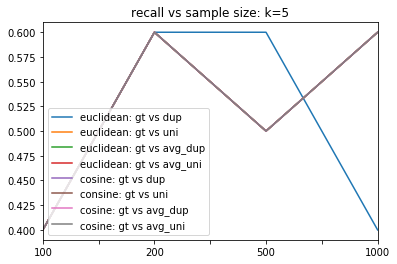

In [35]:
values_5 = [k_5_100_m, k_5_200_m, k_5_500_m, k_5_1000_m]
create_df_line(values_5, 5)

In [36]:
lst_10 = combine_8funcs(10)
# find median
k_10_100_m = med(lst_10[0])
k_10_200_m = med(lst_10[1])
k_10_500_m = med(lst_10[2])
k_10_1000_m = med(lst_10[3])

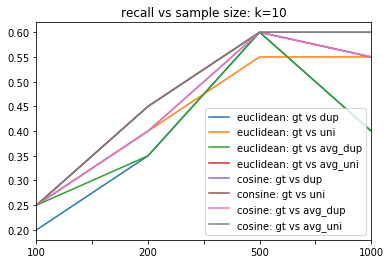

In [37]:
values_10 = [k_10_100_m, k_10_200_m, k_10_500_m, k_10_1000_m]
create_df_line(values_10, 10)

***
## Top 4 graphs

In [38]:
def tanimoto_euclidean_2(moldb, k, radius):
    lst1, lst2 = [], []
    query_size = 20
    
    for i in range(query_size):
        gt_rankings = tanimoto_similarity(moldb, i)
        #dup_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_duplicates)
        uni_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_unique)
        #avg_dup_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_average_dup)
        avg_uni_rankings = mol2vec_euclidean_similarity(moldb, i, radius, mol2vec_average_uni)

        lst1.append(compare_rankings_recall(gt_rankings, uni_rankings, k))
        lst2.append(compare_rankings_recall(gt_rankings, avg_uni_rankings, k))
    
    return [lst1, lst2]

In [39]:
def tanimoto_cosine_2(moldb, k, radius):
    lst1, lst2 = [], []
    query_size = 20

    for i in range(query_size):
        gt_rankings = tanimoto_similarity(moldb, i)
        #dup_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_duplicates)
        uni_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_unique)
        #avg_dup_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_average_dup)
        avg_uni_rankings = mol2vec_cosine_similarity(moldb, i, radius, mol2vec_average_uni)

        lst1.append(compare_rankings_recall(gt_rankings, uni_rankings, k))
        lst2.append(compare_rankings_recall(gt_rankings, avg_uni_rankings, k))
    
    return [lst1, lst2]

In [40]:
# k=10
# put 8 functions together for all sample sizes
k_10_100 = tanimoto_euclidean_2(c_small_moldb100, 10, 1)+tanimoto_cosine_2(c_small_moldb100, 10, 1)
k_10_200 = tanimoto_euclidean_2(c_small_moldb200, 10, 1)+tanimoto_cosine_2(c_small_moldb200, 10, 1)
k_10_500 = tanimoto_euclidean_2(c_small_moldb500, 10, 1)+tanimoto_cosine_2(c_small_moldb500, 10, 1)
k_10_1000 = tanimoto_euclidean_2(c_small_moldb1000, 10, 1)+tanimoto_cosine_2(c_small_moldb1000, 10, 1)
k_10_2000 = tanimoto_euclidean_2(c_small_moldb2000, 10, 1)+tanimoto_cosine_2(c_small_moldb2000, 10, 1)
k_10_5000 = tanimoto_euclidean_2(c_small_moldb5000, 10, 1)+tanimoto_cosine_2(c_small_moldb5000, 10, 1)

In [42]:
# takes in a list of lists, returns a list of median of all lists
def med(lst):
    med_lst = []
    
    for i in lst:
        med = np.median(i)
        med_lst.append(med)
    
    return med_lst

In [43]:
# find median
k_10_100_m = med(k_10_100)
k_10_200_m = med(k_10_200)
k_10_500_m = med(k_10_500)
k_10_1000_m = med(k_10_1000)
k_10_2000_m = med(k_10_2000)
k_10_5000_m = med(k_10_5000)

In [45]:
# put into df
values = [k_10_100_m, k_10_200_m, k_10_500_m, k_10_1000_m, k_10_2000_m, k_10_5000_m]
cols = ['euclidean: gt vs uni', 'euclidean: gt vs avg_uni', 
       'cosine: gt vs uni', 'cosine: gt vs avg_uni']
df = pd.DataFrame(values, index=['100', '200', '500', '1000', '2000', '5000'], columns=cols)

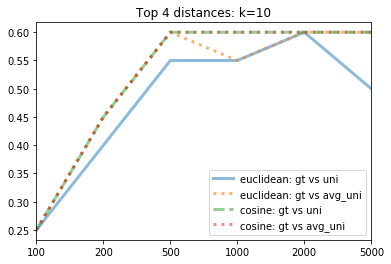

In [46]:
ls = [':', '-', '--', '-.']
fig, ax = plt.subplots()
df.plot(y=0, kind='line', ax=ax, linestyle=ls[1], linewidth=3, alpha=0.5)
df.plot(y=1, kind='line', ax=ax, linestyle=ls[0], linewidth=3, alpha=0.6)
df.plot(y=2, kind='line', ax=ax, linestyle=ls[2], linewidth=3, alpha=0.5)
df.plot(y=3, kind='line', ax=ax, linestyle=ls[0], linewidth=3, alpha=0.5)
plt.title('Top 4 distances: k=10')
plt.legend(loc='lower right')